## Figure 3

- Panel A: Confusion matrix for test set performance in real and shuffled models
- Panel B: Precision recall curves for all 15 phenotypes
- Panel C: F1 scores

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [2]:
figure_dir <- "figures"
output_main_figure_3 <- file.path(figure_dir, "main_figure_3_multiclass_model_eval.png")
output_sup_fig_corr <- file.path(figure_dir, "supplementary", "supplementary_pairwise_correlations.png")

In [3]:
# Load confustion matrix data
cm_dir <- file.path("../3.evaluate_model/evaluations/confusion_matrices")
cm_file <- file.path(cm_dir, "compiled_cm_data.tsv")

cm_df <- readr::read_tsv(
    cm_file,
    col_types = readr::cols(
        .default = "c",
        shuffled = "l",
        Count = "d"
    )
) %>%
    dplyr::select(!...1) %>%
    dplyr::group_by(True_Label, data_split, shuffled, feature_type) %>%
    dplyr::mutate(
        total_count = sum(Count),
        ratio = Count / total_count
    )

# Reverse order of predicted label for plotting
cm_df$Predicted_Label <-
    factor(cm_df$Predicted_Label, levels = rev(unique(cm_df$Predicted_Label)))

# Order feature types for plotting
cm_df$feature_type <-
    dplyr::recode_factor(cm_df$feature_type, !!!facet_labels)

head(cm_df)

New names:
• `` -> `...1`


True_Label,Predicted_Label,Count,data_split,shuffled,feature_type,total_count,ratio
<chr>,<fct>,<dbl>,<chr>,<lgl>,<fct>,<dbl>,<dbl>
ADCCM,ADCCM,72,train,FALSE,CellProfiler,81,0.88888889
ADCCM,Anaphase,0,train,FALSE,CellProfiler,81,0.00000000
ADCCM,Apoptosis,1,train,FALSE,CellProfiler,81,0.01234568
ADCCM,Binuclear,0,train,FALSE,CellProfiler,81,0.00000000
ADCCM,Elongated,0,train,FALSE,CellProfiler,81,0.00000000
ADCCM,Grape,0,train,FALSE,CellProfiler,81,0.00000000


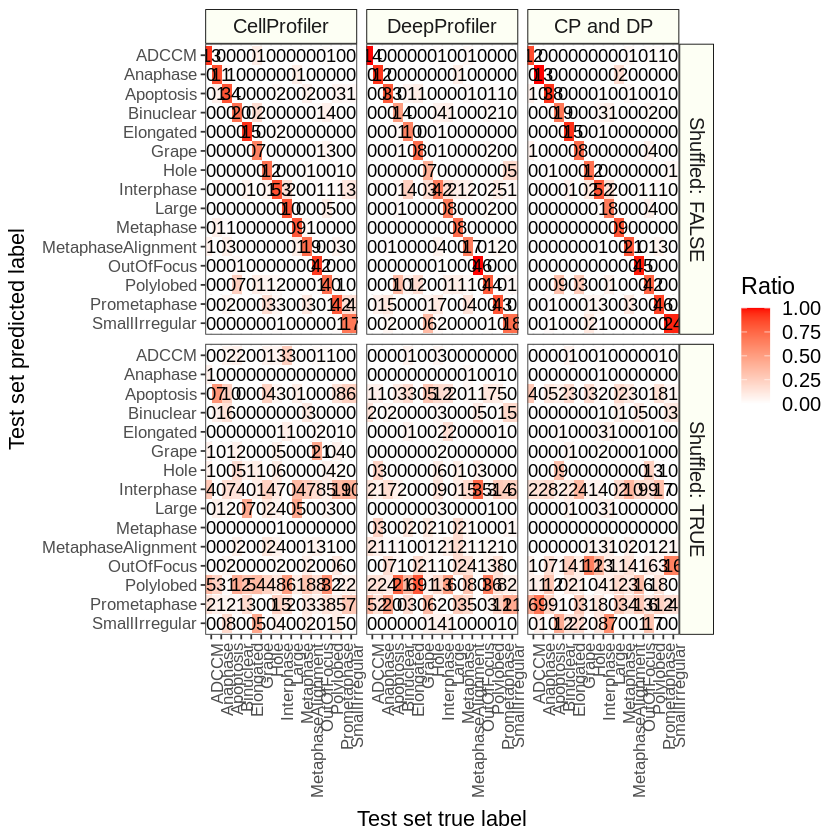

In [4]:
custom_labeller <- function(value) {
  paste("Shuffled:", value)
}

confusion_matrix_gg <- (
    ggplot(
        cm_df %>%
            dplyr::filter(data_split == "test"),
        aes(x = True_Label, y = Predicted_Label)
    )
    + facet_grid("shuffled~feature_type", labeller = labeller(shuffled = custom_labeller))
    + geom_point(aes(color = ratio), size = 5, shape = 15)
    + geom_text(aes(label = Count))
    + scale_color_gradient("Ratio", low = "white", high = "red")
    + theme_bw()
    + phenotypic_ggplot_theme
    + theme(
        axis.text.x = element_text(angle = 90, hjust = 1, size = 10),
        axis.title = element_text(size = 13),
        axis.text.y = element_text(size = 10),
        strip.text = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
    )
    + labs(x = "Test set true label", y = "Test set predicted label")
)

confusion_matrix_gg

## Generate precision recall curves

In [5]:
# Load data
results_dir <- file.path(
    "..", "3.evaluate_model", "evaluations", "precision_recall_curves"
)
results_file <- file.path(results_dir, "compiled_class_PR_curves.tsv")

pr_df <- readr::read_tsv(
    results_file,
    col_types = readr::cols(
        .default = "d",
        "Phenotypic_Class" = "c",
        "data_split" = "c",
        "shuffled" = "c",
        "feature_type" = "c"
    )
) %>%
    dplyr::select(!`...1`) %>%
    dplyr::mutate(feature_type_with_data_split = paste0(feature_type, data_split))

print(dim(pr_df))
head(pr_df)

New names:
• `` -> `...1`


[1] 257580      8


Phenotypic_Class,PR_Threshold,Precision,Recall,data_split,shuffled,feature_type,feature_type_with_data_split
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ADCCM,4.814030e-17,0.03330592,1,train,False,CP,CPtrain
ADCCM,8.830557e-15,0.03331962,1,train,False,CP,CPtrain
ADCCM,1.573919e-14,0.03333333,1,train,False,CP,CPtrain
ADCCM,1.657817e-14,0.03334706,1,train,False,CP,CPtrain
ADCCM,4.481554e-14,0.03336079,1,train,False,CP,CPtrain
ADCCM,4.489999e-14,0.03337454,1,train,False,CP,CPtrain


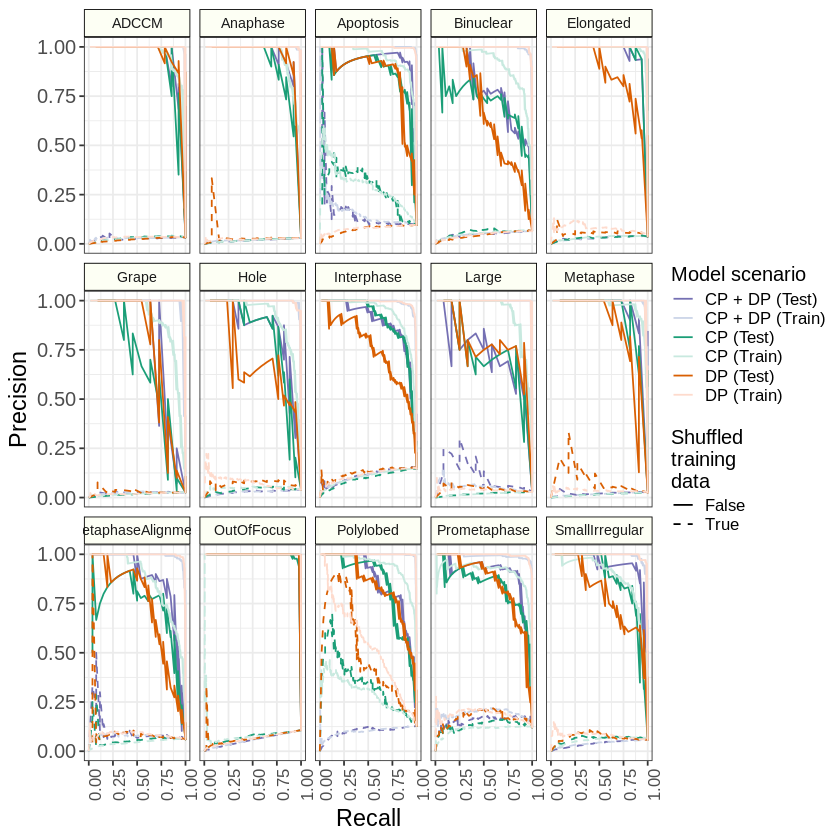

In [6]:
pr_curve_gg <- (
    ggplot(pr_df, aes(x = Recall, y = Precision))
    + geom_line(aes(color = feature_type_with_data_split, linetype = shuffled))
    + facet_wrap("~Phenotypic_Class", nrow = 3)
    + theme_bw()
    + xlab("Recall")
    + ylab("Precision")
    + scale_color_manual(
        name = "Model scenario",
        labels = feature_type_with_data_split_labels,
        values = feature_type_with_data_split_colors
    )
    + scale_linetype_manual(
        name = "Shuffled\ntraining\ndata",
        labels = shuffled_labels,
        values = shuffled_linetypes
    )
    + guides(
        color = guide_legend(order = 1),
        linetype = guide_legend(order = 2),
    )
    + phenotypic_ggplot_theme
    # Decrease spacing in legend
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90),
        strip.text = element_text(size = 8.5),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14)
    )
)

pr_curve_gg

## F1 score summary

In [7]:
# Load data
results_dir <- file.path(
    "..", "3.evaluate_model", "evaluations", "F1_scores"
)
results_file <- file.path(results_dir, "compiled_F1_scores.tsv")

f1_score_df <- readr::read_tsv(
    results_file,
    col_types = readr::cols(
        .default = "d",
        "Phenotypic_Class" = "c",
        "data_split" = "c",
        "shuffled" = "c",
        "feature_type" = "c"
    )
) %>%
    dplyr::select(!`...1`) %>%
    dplyr::mutate(feature_type_with_data_split = paste0(feature_type, data_split)) %>%
    dplyr::filter(data_split == "test")

f1_score_df$Phenotypic_Class <-
    dplyr::recode(f1_score_df$Phenotypic_Class, Weighted = "OverallPerformance")

# Reverse order of predicted label for plotting
front_level <- "OverallPerformance"
remaining_levels <- setdiff(unique(f1_score_df$Phenotypic_Class), front_level)
new_order <- c(rev(remaining_levels), front_level)

f1_score_df$Phenotypic_Class <-
    factor(f1_score_df$Phenotypic_Class, levels = new_order)

print(dim(f1_score_df))
head(f1_score_df)

New names:
• `` -> `...1`


[1] 96  6


Phenotypic_Class,F1_Score,data_split,shuffled,feature_type,feature_type_with_data_split
<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>
ADCCM,0.8965517,test,False,CP,CPtest
Anaphase,0.8461538,test,False,CP,CPtest
Apoptosis,0.8095238,test,False,CP,CPtest
Binuclear,0.7272727,test,False,CP,CPtest
Elongated,0.9090909,test,False,CP,CPtest
Grape,0.6363636,test,False,CP,CPtest


In [8]:
# How many of the phenotypic classes are certain feature types the best?
top_scores_df <- f1_score_df %>%
    dplyr::arrange(desc(F1_Score)) %>%
    dplyr::group_by(Phenotypic_Class) %>%
    dplyr::slice(1)

print(table(top_scores_df$feature_type_with_data_split))

top_scores_df


CP_and_DPtest        CPtest        DPtest 
           10             3             3 


Phenotypic_Class,F1_Score,data_split,shuffled,feature_type,feature_type_with_data_split
<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>
SmallIrregular,0.9056604,test,False,CP_and_DP,CP_and_DPtest
Prometaphase,0.8679245,test,False,CP_and_DP,CP_and_DPtest
Polylobed,0.7636364,test,False,CP_and_DP,CP_and_DPtest
OutOfFocus,0.9892473,test,False,DP,DPtest
MetaphaseAlignment,0.8076923,test,False,CP_and_DP,CP_and_DPtest
Metaphase,0.9000000,test,False,CP_and_DP,CP_and_DPtest
Large,0.7407407,test,False,CP,CPtest
Interphase,0.8455285,test,False,CP_and_DP,CP_and_DPtest
Hole,0.7741935,test,False,CP,CPtest


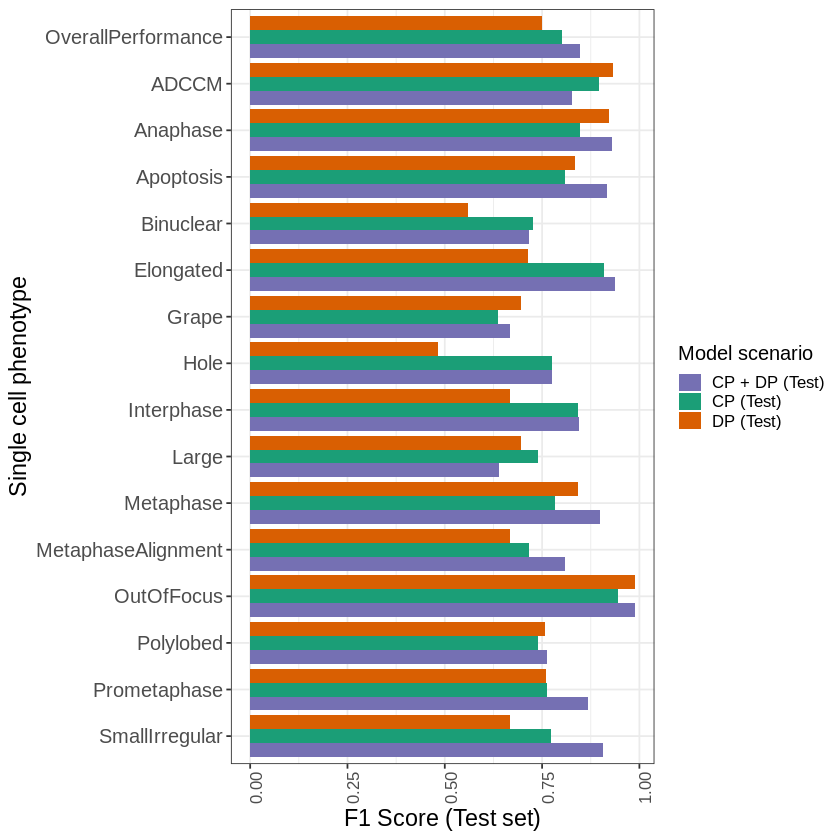

In [9]:
f1_score_gg <- (
    ggplot(f1_score_df, aes(x = Phenotypic_Class, y = F1_Score))
    + geom_bar(aes(fill = feature_type_with_data_split), stat = "identity", position = "dodge")
    + theme_bw()
    + xlab("Single cell phenotype")
    + ylab("F1 Score (Test set)")
    + scale_fill_manual(
        name = "Model scenario",
        labels = feature_type_with_data_split_labels,
        values = feature_type_with_data_split_colors
    )
    + phenotypic_ggplot_theme
    # Decrease spacing in legend and rotate text
    + theme(
        legend.spacing.y = unit(0.2, "cm"),
        legend.box.spacing = unit(0.3, "cm"),
        legend.key.size = unit(0.8, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14)
    )
    + coord_flip()
)

f1_score_gg

## Compile full figure 3

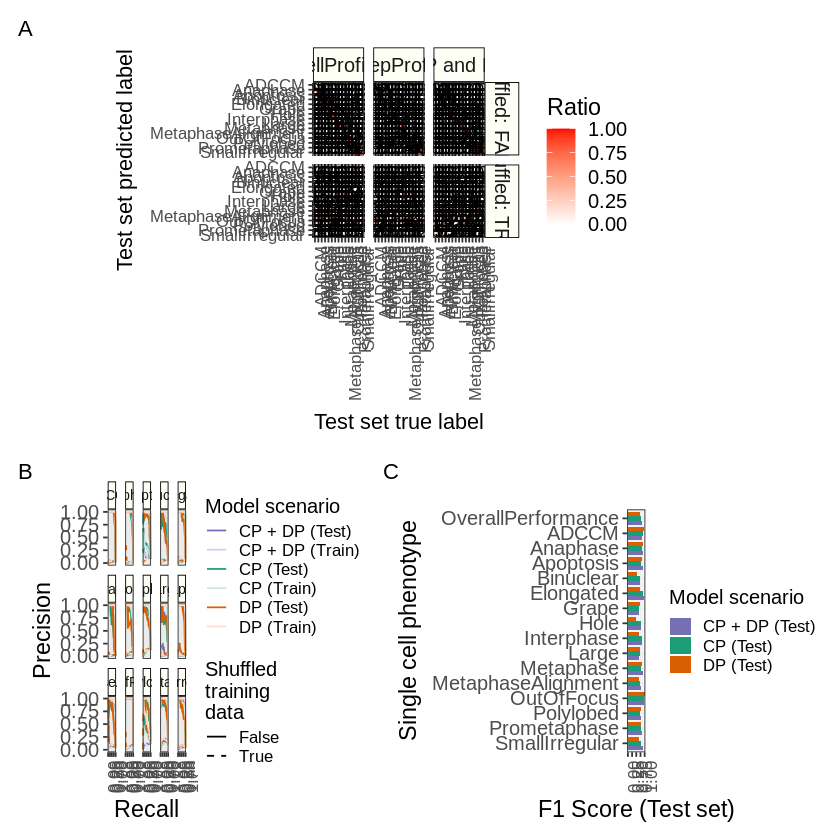

In [10]:
bottom_plot <- (
    pr_curve_gg | 
    f1_score_gg
) + plot_layout(widths = c(3, 0.7))

fig_3_gg <- (
    wrap_elements(confusion_matrix_gg) /
    bottom_plot
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(1, 0.6))

ggsave(output_main_figure_3, dpi = 500, height = 14, width = 14)

fig_3_gg